label
0    7408
1     423
Name: count, dtype: int64
------------------
label
0    7408
1     423
Name: count, dtype: int64
label
0    7408
1    7408
Name: count, dtype: int64


[23:52:13] Explicit valence for atom # 5 Al, 6, is greater than permitted
[23:52:16] Explicit valence for atom # 3 Al, 6, is greater than permitted
[23:52:16] Explicit valence for atom # 4 Al, 6, is greater than permitted
[23:52:16] Explicit valence for atom # 9 Al, 6, is greater than permitted
[23:52:18] Explicit valence for atom # 4 Al, 6, is greater than permitted
[23:52:18] Explicit valence for atom # 14 Al, 6, is greater than permitted
[23:52:18] WARNING: not removing hydrogen atom without neighbors
[23:52:23] Explicit valence for atom # 8 Al, 6, is greater than permitted
[23:52:26] Explicit valence for atom # 20 Al, 6, is greater than permitted



Model: SVM
Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       0.72      0.71      0.71      1476
       Toxic       0.71      0.72      0.72      1486

    accuracy                           0.71      2962
   macro avg       0.71      0.71      0.71      2962
weighted avg       0.71      0.71      0.71      2962

Accuracy: 0.71
ROC-AUC Score: 0.78

Model: KNN
Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       0.91      0.65      0.76      1476
       Toxic       0.73      0.94      0.82      1486

    accuracy                           0.80      2962
   macro avg       0.82      0.80      0.79      2962
weighted avg       0.82      0.80      0.79      2962

Accuracy: 0.80
ROC-AUC Score: 0.89

Model: RandomForest
Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       1.00      0.90      0.95      1476
       Toxic       0.91      1.00      0.95      1486

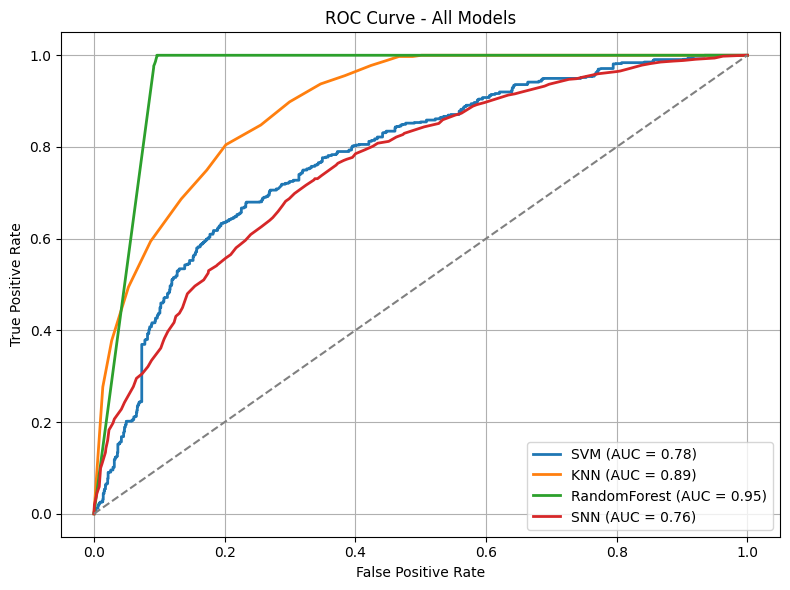

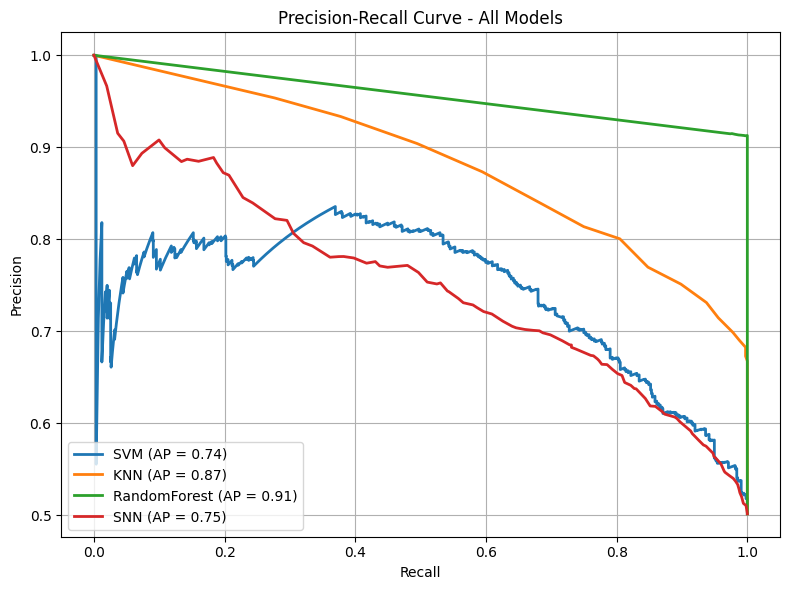

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.utils import resample
from minisom import MiniSom

# Load dataset
file_path = r"C:\Users\Sushma\Desktop\Acadamics\4th sem\BIO-2\project\tox21.csv"
data = pd.read_csv(file_path)
print(data['label'].value_counts())

# Remove duplicates and reset index
data = data.drop_duplicates(subset='smiles').reset_index(drop=True)
print("------------------")
print(data['label'].value_counts())

# Oversampling to balance dataset
majority = data[data.label == 0]
minority = data[data.label == 1]

minority_oversampled = resample(minority, 
                                replace=True, 
                                n_samples=len(majority), 
                                random_state=42)

data_balanced = pd.concat([majority, minority_oversampled]).reset_index(drop=True)
print(data_balanced['label'].value_counts())

# Convert SMILES to descriptors
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return {
            "MolecularWeight": Descriptors.MolWt(mol),
            "NumAtoms": Descriptors.HeavyAtomCount(mol),
            "NumRotatableBonds": Descriptors.NumRotatableBonds(mol),
            "LogP": Descriptors.MolLogP(mol),
        }
    else:
        return {"MolecularWeight": np.nan, "NumAtoms": np.nan, "NumRotatableBonds": np.nan, "LogP": np.nan}

descriptors = data_balanced["smiles"].apply(calculate_descriptors)
descriptors_df = pd.DataFrame(descriptors.tolist())

data_balanced = pd.concat([descriptors_df, data_balanced["label"]], axis=1).dropna()

# Features and target
X = data_balanced.drop("label", axis=1)
y = data_balanced["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define traditional models
models = {
    "SVM": SVC(kernel="rbf", probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=20),
    "RandomForest": RandomForestClassifier(n_estimators=1, random_state=42)
}

# Store ROC and PR data
roc_data = {}
pr_data = {}

# Train and evaluate traditional models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"\nModel: {name}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["Non-Toxic", "Toxic"]))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.2f}")
    
    # Store ROC/PR info
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    roc_data[name] = (fpr, tpr, auc(fpr, tpr))
    pr_data[name] = (recall, precision, average_precision_score(y_test, y_proba))

# ----------- Self-Organizing Map (SNN) ------------
print("\nModel: Self-Organizing Neural Network (SNN)")

som = MiniSom(x=10, y=10, input_len=X_train.shape[1], sigma=1.0, learning_rate=0.7, random_seed=42)
som.train_random(X_train, num_iteration=1000)

def get_som_features(som, data):
    som_x, som_y = som._weights.shape[:2]
    features = np.zeros((data.shape[0], som_x * som_y))
    for i, sample in enumerate(data):
        x, y = som.winner(sample)
        features[i, x * som_y + y] = 1
    return features

X_train_som = get_som_features(som, X_train)
X_test_som = get_som_features(som, X_test)

rf_on_snn = RandomForestClassifier(n_estimators=100, random_state=42)
rf_on_snn.fit(X_train_som, y_train)

y_pred_snn = rf_on_snn.predict(X_test_som)
y_proba_snn = rf_on_snn.predict_proba(X_test_som)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred_snn, target_names=["Non-Toxic", "Toxic"]))
print(f"Accuracy: {accuracy_score(y_test, y_pred_snn):.2f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_snn):.2f}")

# Store SNN ROC/PR
fpr, tpr, _ = roc_curve(y_test, y_proba_snn)
precision, recall, _ = precision_recall_curve(y_test, y_proba_snn)
roc_data["SNN"] = (fpr, tpr, auc(fpr, tpr))
pr_data["SNN"] = (recall, precision, average_precision_score(y_test, y_proba_snn))

# ================= PLOT ROC CURVES =================
plt.figure(figsize=(8, 6))
for model_name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - All Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# ============= PLOT PRECISION-RECALL CURVES =============
plt.figure(figsize=(8, 6))
for model_name, (recall, precision, ap) in pr_data.items():
    plt.plot(recall, precision, lw=2, label=f"{model_name} (AP = {ap:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - All Models")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()


Ensemble Model Accuracy: 0.9831
Ensemble Model F1 Score: 0.9830
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1516
           1       0.97      1.00      0.98      1448

    accuracy                           0.98      2964
   macro avg       0.98      0.98      0.98      2964
weighted avg       0.98      0.98      0.98      2964



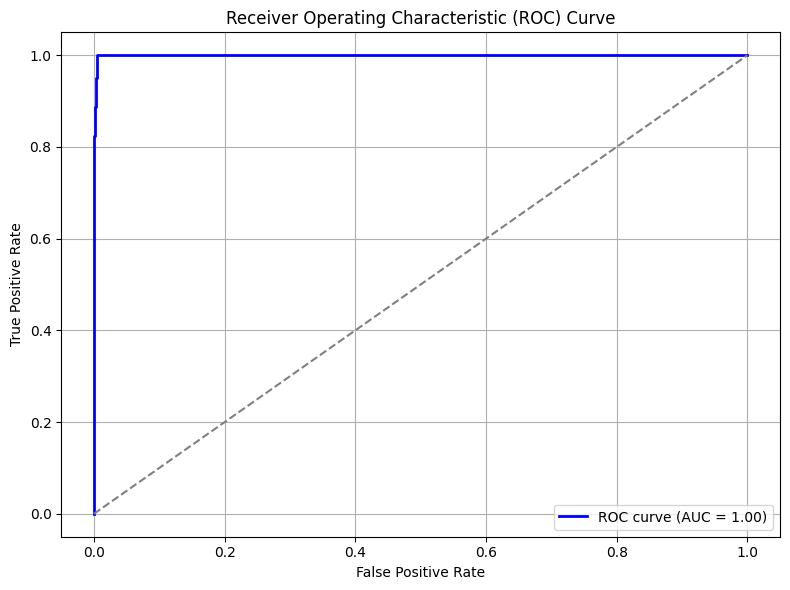

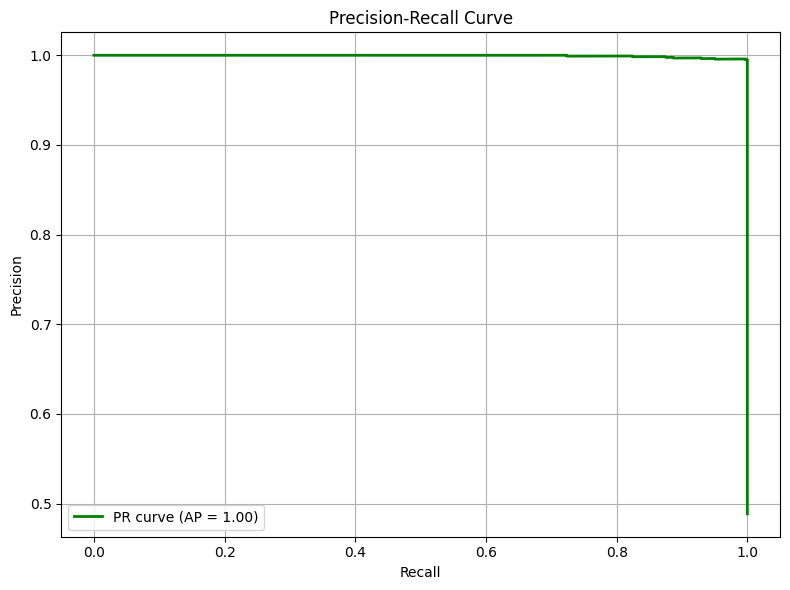

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.utils import resample

# Load the dataset
data = pd.read_csv(r"C:\Users\Sushma\Desktop\Acadamics\4th sem\BIO-2\project\tox21.csv")

# Drop duplicates and NaNs if necessary
data = data.drop_duplicates(subset="smiles").dropna(subset=["smiles", "label"]).reset_index(drop=True)

# Balance the dataset using oversampling
majority = data[data['label'] == 0]
minority = data[data['label'] == 1]

minority_oversampled = resample(minority, 
                                replace=True, 
                                n_samples=len(majority), 
                                random_state=42)

data_balanced = pd.concat([majority, minority_oversampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# Encode SMILES strings to fixed-length numeric arrays
def smiles_to_placeholder(smiles_list, max_length=100):
    encoded = []
    for smiles in smiles_list:
        numeric = [ord(char) for char in smiles[:max_length]]
        padded = numeric + [0] * (max_length - len(numeric)) if len(numeric) < max_length else numeric
        encoded.append(padded)
    return np.array(encoded)

# Encode and prepare features and labels
X = smiles_to_placeholder(data_balanced['smiles'])
y = data_balanced['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize individual models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
svm = SVC(probability=True)

# Fit individual models
rf.fit(X_train, y_train)
knn.fit(X_train, y_train)
svm.fit(X_train, y_train)

# Create and train ensemble VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('rf', rf),
    ('knn', knn),
    ('svm', svm)
], voting='soft', weights=[0.5, 0.3, 0.3])

ensemble_model.fit(X_train, y_train)

# Predict and evaluate
final_preds = ensemble_model.predict(X_test)
accuracy = accuracy_score(y_test, final_preds)
f1 = f1_score(y_test, final_preds)

print(f"Ensemble Model Accuracy: {accuracy:.4f}")
print(f"Ensemble Model F1 Score: {f1:.4f}")
print(classification_report(y_test, final_preds))

# ======== ROC and Precision-Recall Curves =========

# Get probability predictions for ROC and PR curve
y_proba = ensemble_model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()


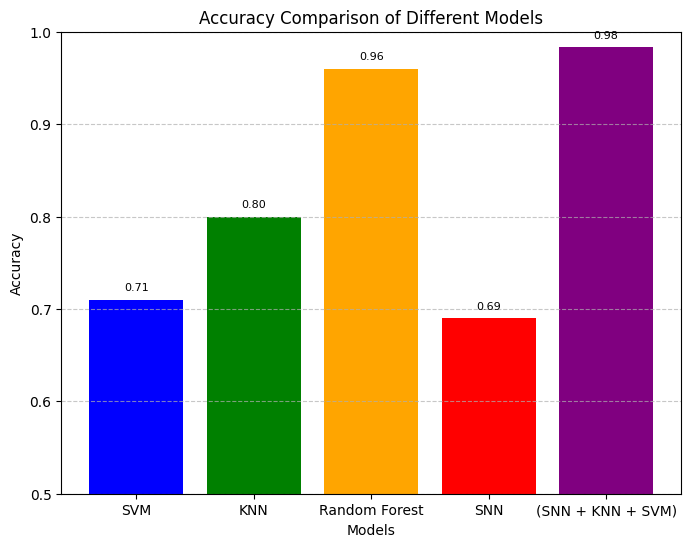

In [7]:
import matplotlib.pyplot as plt

# Define model names and their corresponding accuracies
models = ["SVM", "KNN", "Random Forest", "SNN", "(SNN + KNN + SVM)"]
accuracies = [0.71, 0.80, 0.96, 0.69, 0.9831]  # Replace with actual accuracy values

# Plot the accuracies
plt.figure(figsize=(8,6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red', 'purple'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of Different Models")
plt.ylim(0.5, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display values on bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=8)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


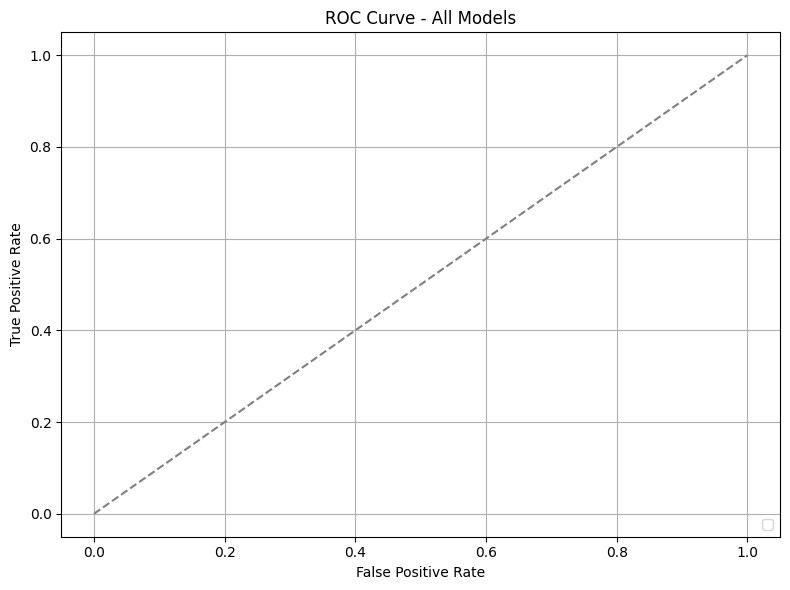

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


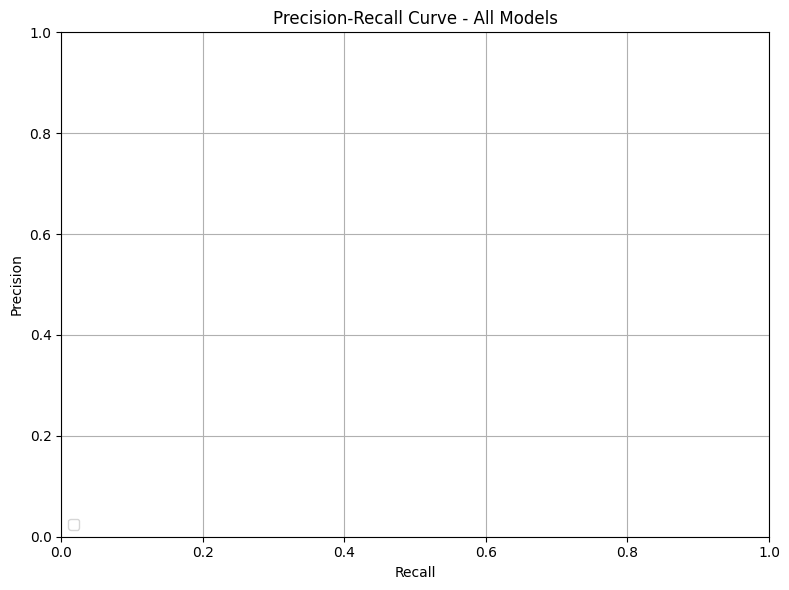

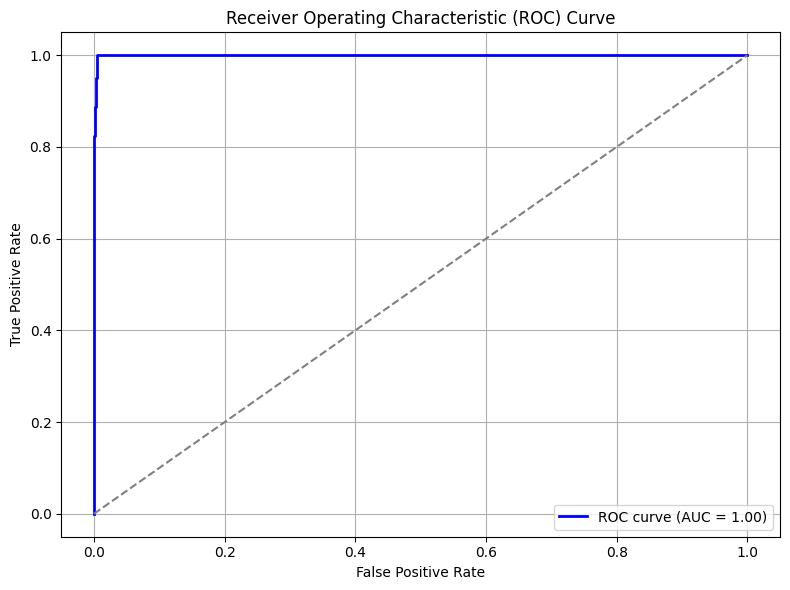

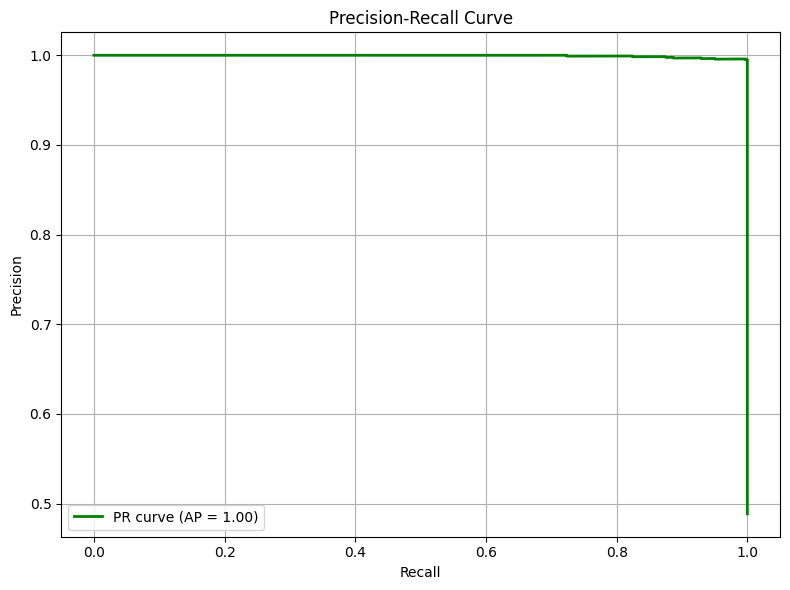

In [28]:

# ================= PLOT ROC CURVES =================
plt.figure(figsize=(8, 6))
for model_name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - All Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# ============= PLOT PRECISION-RECALL CURVES =============
plt.figure(figsize=(8, 6))
for model_name, (recall, precision, ap) in pr_data.items():
    plt.plot(recall, precision, lw=2, label=f"{model_name} (AP = {ap:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - All Models")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()


# ======== ROC and Precision-Recall Curves =========

# Get probability predictions for ROC and PR curve
y_proba = ensemble_model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()



In [29]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# ========== Calculate ROC and PR Data ==========
roc_data = {}
pr_data = {}

for model_name, (y_true, y_proba) in stored_probs.items():
    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    roc_data[model_name] = (fpr, tpr, roc_auc)

    # PR
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    ap_score = average_precision_score(y_true, y_proba)
    pr_data[model_name] = (recall, precision, ap_score)

# ========== Plot ROC Curves ==========
plt.figure(figsize=(8, 6))
for model_name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - All Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Plot Precision-Recall Curves ==========
plt.figure(figsize=(8, 6))
for model_name, (recall, precision, ap) in pr_data.items():
    plt.plot(recall, precision, lw=2, label=f"{model_name} (AP = {ap:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - All Models")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'stored_probs' is not defined